In [1]:
import os
import random

import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
import torch.backends.mps
from torch.utils.data import DataLoader, random_split

from utils.dl.niab import (COMMON_TRANSFORMS, IMG_TRANSFORMS, MASK_TRANSFORMS,
                           SegmentationDataset)

# https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/train.py

/home/users/ashine/miniconda3/envs/niab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/users/ashine/miniconda3/envs/niab/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Size of dataset: 280
Image shape: torch.Size([256, 256])
Unique values in mask: tensor([0., 1.])


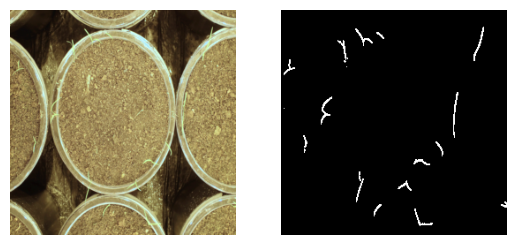

In [3]:
niab_dataset = SegmentationDataset(
    "../datasets/niab/EXP01/Top_Images/Annotated_Dataset_Fully_Corrected/imgs",
    "../datasets/niab/EXP01/Top_Images/Annotated_Dataset_Fully_Corrected/masks",
    img_transforms=IMG_TRANSFORMS,
    mask_transforms=MASK_TRANSFORMS,
    common_transforms=COMMON_TRANSFORMS,
)

# Could change the dimention to be 512 (512/16=32 (given that 2^5=32 and resnet34 has 5 layers of downsampling by a factor of 2))

random_index = random.randint(0, len(niab_dataset) - 1)
image, mask = niab_dataset[random_index]

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(
    image.permute(1, 2, 0)
)  # permute to change the order of the channels so that it can be displayed correctly
plt.axis("off")

# Plot mask
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0), cmap="gray")
plt.axis("off")

print(f"Size of dataset: {len(niab_dataset)}")
print(f"Image shape: {image[1].shape}")

# TODO: Be sure that the segmentation masks are binary and not RGB
# I am pretty sure at the moment that the masks are RGB as they are a jpeg image and not a png image - I need to convert them to greyscale
print(f"Unique values in mask: {torch.unique(mask)}")

plt.show()

In [4]:
# Split the dataset into training and validation sets
total_size = len(niab_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
training_dataset, validation_dataset = random_split(
    niab_dataset, [train_size, val_size]
)

# How much data?
print(f"Size of training dataset: {len(training_dataset)}")
print(f"Size of validation dataset: {len(validation_dataset)}")

# Post-transformation, what does the data look like?
print(f"Shape of first input entry (post-transformation): {niab_dataset[0][0].shape}")
print(f"Shape of first label entry (post-transformation): {niab_dataset[0][1].shape}")

# Print the unique values in the mask
print(f"Unique values in mask: {torch.unique(niab_dataset[0][1])}")

Size of training dataset: 224
Size of validation dataset: 56
Shape of first input entry (post-transformation): torch.Size([3, 256, 256])
Shape of first label entry (post-transformation): torch.Size([1, 256, 256])
Unique values in mask: tensor([0., 1.])


In [86]:
# Parameters
# https://ai.stackexchange.com/questions/8560/how-do-i-choose-the-optimal-batch-size
# https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu
# It has been observed that with larger batch there is a significant degradation in the quality of the model, as
# measured by its ability to generalize i.e. large batch size is better for training but not for generalization
# (overfitting)
BATCH_SIZE = 2**4  # should be divisible by the training dataset size
EPOCHS = 5

# Detect device for training and running the model
# Installing CUDA - https://docs.nvidia.com/cuda/cuda-quick-start-guide/
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Training/fitting using {device} device")

# Create a data loader to handle loading data in and out of memory in batches

# Create data loaders.
train_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Look at the shape of the data coming out of the data loader (batch size, channels, height, width)
for X, y in validation_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Create an instance of the model and move it to the device (GPU or CPU)
model = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
).to(device)


def fit(dataloader, model, loss_fn, optimizer, scheduler, device, log_freq=10) -> None:
    """
    Fit the model to the data using the loss function and optimizer
    Taken from the official PyTorch quickstart tutorial (https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters)
    :param dataloader:
    :param model:
    :param loss_fn:
    :param optimizer:
    :param scheduler:
    :param device:
    :param log_freq:
    :return: None
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # move data to device (GPU or CPU), ensure that the data and model are on the same device
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)  # forward pass
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()  # backward pass (calculate gradients)
        optimizer.step()  # update params
        optimizer.zero_grad()  # reset gradients to zero
        # scheduler.step()  # update learning rate (decay)

        # To avoid too much output, only print every n batches (log_freq), by default every 10 batches
        if batch % log_freq == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def validate(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    total_loss, total_precision, total_recall, total_f1, total_iou = 0, 0, 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item()

            # Convert predictions to binary class labels
            pred_binary = (pred > 0.5).float()

            # Calculate metrics

    # Calculate averages
    avg_loss = total_loss / num_batches
    # avg_precision = total_precision / num_batches
    # avg_recall = total_recall / num_batches
    # avg_f1 = total_f1 / num_batches
    # avg_iou = total_iou / num_batches

    print(f"Validation Metrics: Avg loss: {avg_loss:>8f}")
    return avg_loss


# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=3e-4
)  # high learning rate and allow it to decay
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # decay the learning rate by a factor of 0.1 every epoch

# Setting up directory to save models
os.makedirs("../models", exist_ok=True)

best_loss = float("inf")
for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    fit(train_dataloader, model, loss_fn, optimizer, None, device, log_freq=2)
    val_loss = validate(validation_dataloader, model, loss_fn)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), f"../models/best_model.pth")
        print("Saved best model")
print("Done!")

Training/fitting using cuda device
Shape of X: torch.Size([16, 3, 256, 256])
Shape of y: torch.Size([16, 1, 256, 256]) torch.float32
Epoch 1
-------------------------------
loss: 0.983651  [   16/  224]
loss: 0.946787  [   48/  224]
loss: 0.954124  [   80/  224]
loss: 0.940182  [  112/  224]
loss: 0.967219  [  144/  224]
loss: 0.969680  [  176/  224]
loss: 0.957793  [  208/  224]
Validation Metrics: Avg loss: 0.976667 

Saved best model
Epoch 2
-------------------------------
loss: 0.968997  [   16/  224]
loss: 0.920060  [   48/  224]
loss: 0.935997  [   80/  224]
loss: 0.918076  [  112/  224]


KeyboardInterrupt: 

Running model using cuda device
Unique values in prediction: tensor([0., 1.], device='cuda:0')


(-0.5, 255.5, 255.5, -0.5)

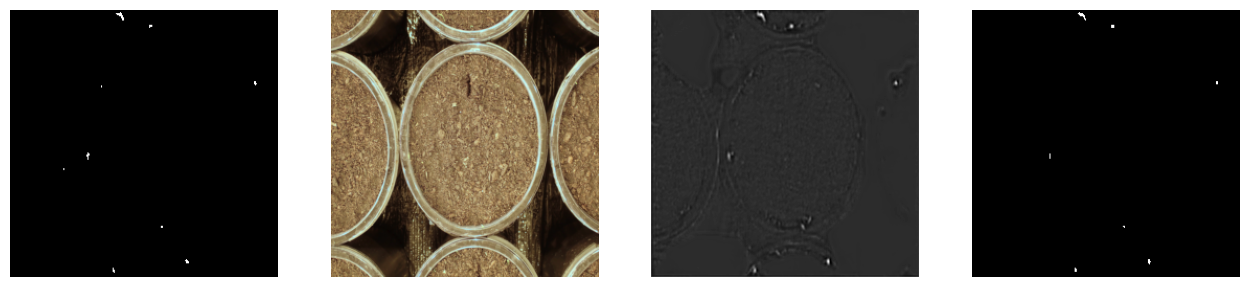

In [13]:
MODEL_PATH = "../models/best_model.pth"

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Running model using {device} device")

random_index = random.randint(
    0, len(validation_dataset) - 1
)  # Take an image at random from the training dataset

# Take a random image from the test dataset
processed_img, processed_mask = validation_dataset[random_index]

# Create an instance of the model and move it to the device (GPU or CPU) and load the model parameters
model = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # Set model to evaluation mode i.e. doesn't change weights

# Make a prediction
pred = model(processed_img.unsqueeze(0).to(device))

threshold = 0.7
pred_binary = (pred > threshold).float()

# check pred_binary is binary
print(f"Unique values in prediction: {torch.unique(pred_binary)}")

# Plot the image, mask and prediction next to each other
plt.figure(figsize=(20, 10))  # Adjust the width (15) and height (5) as needed

# plt.subplot(1, 5, 1)
# plt.imshow(raw_img)
# plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(processed_mask.cpu().detach().permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.subplot(1, 5, 3)
plt.imshow(processed_img.cpu().detach().permute(1, 2, 0))
plt.axis("off")
plt.subplot(1, 5, 4)
plt.imshow(pred[0].cpu().detach().permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.subplot(1, 5, 5)
plt.imshow(
    pred_binary[0].cpu().detach().permute(1, 2, 0), cmap="gray"
)  # quantized after based on prediction estimates
plt.axis("off")